In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings

%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [3]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [4]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [05:27<00:00,  7.37it/s]


Adjacency matrices generated
Pipeline finished


In [5]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

In [59]:
cases = {5: {'min_weight': 0.0, 'max_weight': 0.1, 'description': 'no short, max 10%', 'linestyle': '--'},
         4: {'min_weight': 0.0, 'max_weight': 0.25, 'description': 'no short, max 25%', 'linestyle': '--'},
         3: {'min_weight': 0.0, 'max_weight': 1, 'description': 'no short, max 100%', 'linestyle': '--'},
         2: {'min_weight': -0.3, 'max_weight': 0.1, 'description': 'short 30%, max 10%', 'linestyle': '-'},
        1: {'min_weight': -0.3, 'max_weight': 0.25, 'description': 'short 30%, max 25%', 'linestyle': '-'},
        0: {'min_weight': -0.3, 'max_weight': 1, 'description': 'short 30%, max 100%', 'linestyle': '-'}}

In [11]:
model_dic = {}
SEED = 45

for i in range(6):
    set_seed(SEED)

    model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=1, 
                        min_weight=cases[i]['min_weight'], max_weight=cases[i]['max_weight'])
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    _, _ = train(model, optim, train_dataset, epochs=4,
                                eval_func='sharpe_loss', exp_name=f'exp_2505_constraints_v{i}', neptune_token=NEPTUNE_TOKEN,
                                neptune_project="aibabynin/graphs", tags=["weights_constraints"])
    
    model_dic[i] = {"model": model,
                    "optimizer": optim}

    print(f"{i} is trained")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-37
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-37/metadata
0 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-38
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-38/metadata
1 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-39
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in 

In [13]:
for i in range(6):
    torch.save(model_dic[i]['model'].state_dict(), f"model_weights_cnstr_{i}_sr.pt")


In [14]:
for i in range(6):
    test_weights_matrix = evaluate(model_dic[i]['model'], test_dataset)
    model_dic[i]['test_weights_matrix'] = test_weights_matrix
    
    print(f"{i} is evaluated")

100%|██████████| 511/511 [00:18<00:00, 27.93it/s]


0 is evaluated


100%|██████████| 511/511 [00:21<00:00, 23.33it/s]


1 is evaluated


100%|██████████| 511/511 [00:28<00:00, 18.07it/s]


2 is evaluated


100%|██████████| 511/511 [00:23<00:00, 22.17it/s]


3 is evaluated


100%|██████████| 511/511 [00:21<00:00, 23.25it/s]


4 is evaluated


100%|██████████| 511/511 [00:22<00:00, 22.81it/s]

5 is evaluated


In [111]:
ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

returns_matrix = np.zeros((6, len(ret)))

for i in range(6):

    returns_matrix[i] = (ret * model_dic[i]['test_weights_matrix']).sum(1)

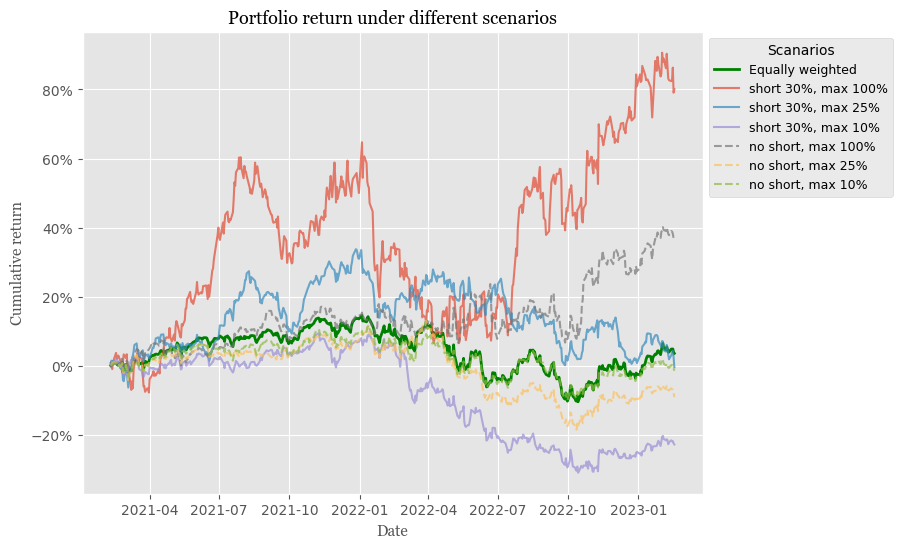

In [31]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted', linewidth=2)

for i in range(6):
    _ = plt.plot(index, (returns_matrix[i]+1).cumprod()- 1, label=cases[i]['description'], alpha=0.7, linestyle=cases[i]['linestyle'])

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different scenarios', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Scanarios', fontsize=9)
plt.show()

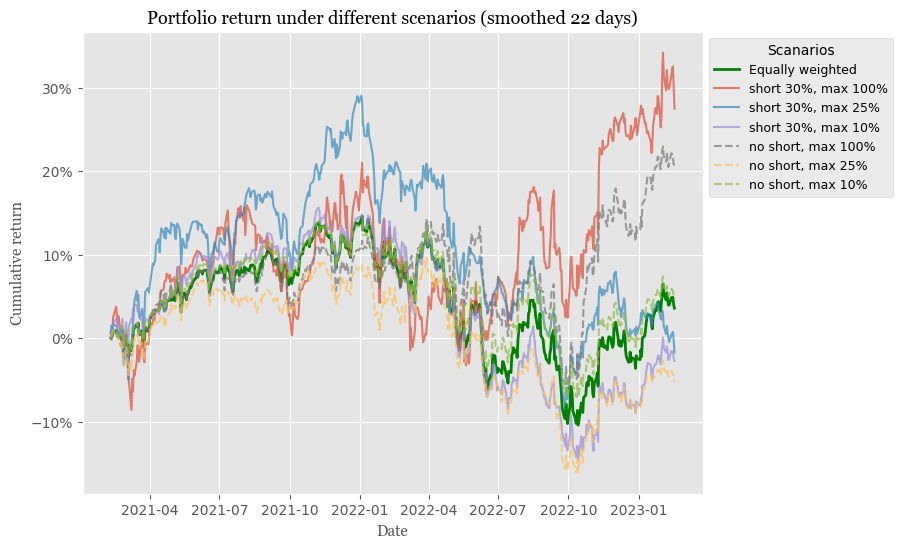

In [121]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted', linewidth=2)

for i in range(6):

    temp = pd.DataFrame(model_dic[i]['test_weights_matrix'], index=index, columns=stocks)
    ema = temp.ewm(span=22).mean().to_numpy()
    p_ret = (ret * ema).sum(1)

    _ = plt.plot(index, (p_ret+1).cumprod()- 1, label=cases[i]['description'], alpha=0.7, linestyle=cases[i]['linestyle'])

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different scenarios (smoothed 22 days)', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Scanarios', fontsize=9)
plt.show()

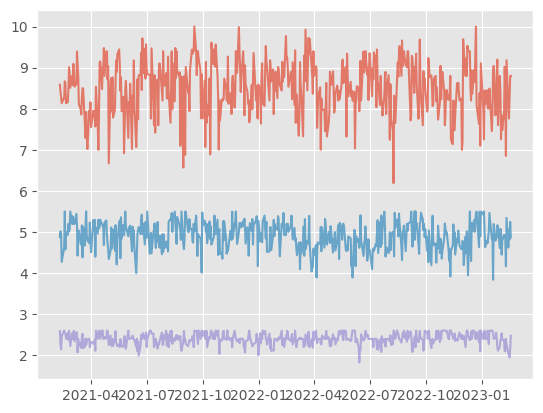

In [122]:
for i in range(3):
    _ = plt.plot(index, np.abs(model_dic[i]['test_weights_matrix']).sum(1), label=cases[i]['description'], alpha=0.7, linestyle=cases[i]['linestyle'])

plt.show()

In [123]:
b_ret = ((ret.mean(1)+1).cumprod()- 1)[-1]
b_std = ret.std() * np.sqrt(len(ret))
b_sr = b_ret / b_std

print(f"Equally weighted portfolio: return = {b_ret:.2%}, std = {b_std:.2%}, sharpe = {b_sr:.2f}")

Equally weighted portfolio: return = 3.61%, std = 31.59%, sharpe = 0.11


In [124]:
#average leverage

for i in range(6):
    if i <3:
        leverage = np.abs(model_dic[i]['test_weights_matrix']).sum(1).mean()
        cases[i]['leverage'] = leverage
        
        print(leverage)
    else:
        cases[i]['leverage'] = 1
    

8.497215567814765
4.906765533815653
2.4008139935221866


In [125]:
for i in range(6):
    ret = ((returns_matrix[i]+1).cumprod()- 1)[-1]
    std = returns_matrix[i].std()*np.sqrt(returns_matrix[i].shape[0])
    cases[i]['sr'] = ret/std
    cases[i]['return']  = ret
    cases[i]['std'] = std

In [126]:
df_stat = pd.DataFrame(cases).T

# style df to round numbers to 2 decimals

df_stat.sort_values(by='sr', ascending=False).style.format("{:.2f}", subset=['leverage', 'sr', 'return', 'std'])


,min_weight,max_weight,description,linestyle,leverage,sr,return,std
0,-0.300000,1,"short 30%, max 100%",-,8.50,1.43,0.80,0.56
3,0.000000,1,"no short, max 100%",--,1.00,1.30,0.38,0.29
1,-0.300000,0.250000,"short 30%, max 25%",-,4.91,-0.01,-0.00,0.30
5,0.000000,0.100000,"no short, max 10%",--,1.00,-0.07,-0.01,0.22
4,0.000000,0.250000,"no short, max 25%",--,1.00,-0.42,-0.09,0.22
2,-0.300000,0.100000,"short 30%, max 10%",-,2.40,-0.84,-0.23,0.27


In [127]:
#count if numpy array >0
arr = model_dic[0]['test_weights_matrix'] 
p = (arr > 0).sum(0) / arr.shape[0]
pd.DataFrame(p, index = stocks, columns=['positive days %']).sort_values(by = 'positive days %', ascending=False).style.format("{:.2f}", subset=['positive days %']).bar()

,positive days %
XLV,0.48
VUG,0.47
XLP,0.44
VNQ,0.41
XLF,0.39
XLY,0.39
SPY,0.38
VTV,0.37
VWO,0.36
SOXX,0.36


### Поробуем протестировать return на разных гаммах

In [132]:
new_dic = {}

for i in tqdm(range(6)):
    model = model_dic[i]['model']
    new_dic[i] = []
    for j in range(10):
        model.gamma = torch.nn.Parameter(torch.FloatTensor([0.01 + 0.01*j]))
        test_weights_matrix = evaluate(model, test_dataset)
        new_dic[i].append(test_weights_matrix)

        


100%|██████████| 6/6 [25:19<00:00, 253.22s/it]


In [137]:
ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

return_dic = {}

for i in range(6):
    return_dic[i] = {'return': [], 'std': [], 'sr': []}

    for j in range(10):
       
        p_ret = (ret * new_dic[i][j]).sum(1)
        cum_return = ((p_ret+1).cumprod()- 1)[-1]
        std = p_ret.std()*np.sqrt(p_ret.shape[0])
        sr = cum_return/std

        return_dic[i]['return'].append(cum_return)
        return_dic[i]['std'].append(std)
        return_dic[i]['sr'].append(sr)



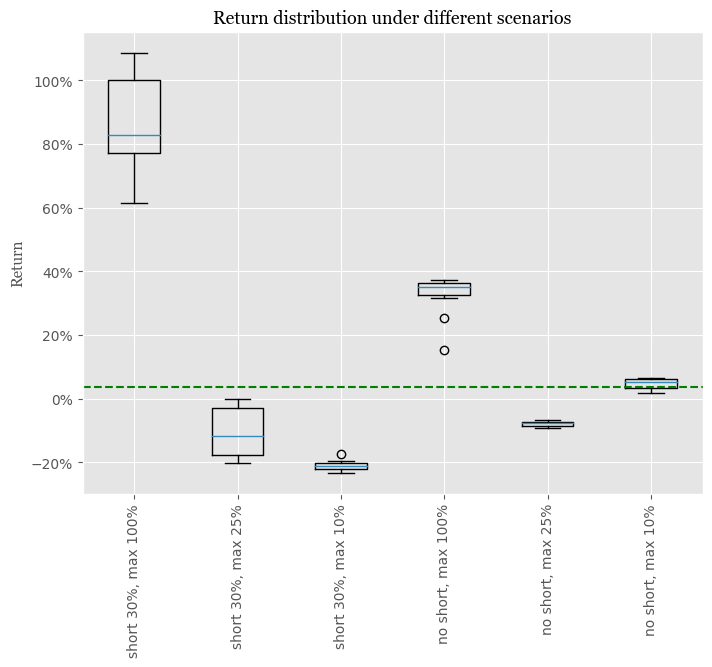

In [141]:
#create box plot of return ddic
plt.figure(figsize=(8, 6))
plt.boxplot([return_dic[i]['return'] for i in range(6)])
plt.xticks([1, 2, 3, 4, 5, 6], [cases[i]['description'] for i in range(6)], rotation=90)
# add horizonta line for equally weighted portfolio
plt.axhline(y=b_ret, color='green', linestyle='--', label='Equally weighted')

plt.ylabel('Return', fontsize=11, fontname='Georgia')
# y ticks to percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Return distribution under different scenarios', fontsize=13, fontname='Georgia')
plt.show()

In [150]:
for i in range(6):
    print(0.01 + 0.01*np.argmin(return_dic[i]['return']))

0.01
0.09999999999999999
0.03
0.01
0.09999999999999999
0.01
